In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from setupFigure import SetupFigure
from dftSlow import dft_coeff, dft_synthesis

In [2]:
def dft_fast_coeff(x):
    """
    Evaluate Fourier coefficients using Numpy's fast Fourier transform.
    This routine only returns the coefficients for the positive frequencies.
    If N is even, it goes up to n=N/2.
    If N is odd, it goes up to n=(N-1)/2.
    :param x: array of function samples
    """
    return np.fft.rfft(x, norm='forward')

In [3]:
def dft_fast_synthesis(fc, outnum='even'):
    """
    Use numpy's fast Fourier synthesis taking only Fourier coefficients for positive frequencies
    :param fc: aray of coefficients for positive frequencies only.
    :param outnum: specifies if output time series has an even or odd number of samples (default: 'even')
    """
    ns = 2*fc.size-2
    if outnum == 'odd': ns = 2*fc.size-1
    return np.fft.irfft(fc, ns, norm='forward')

In [4]:
def boxcar(dt, period, tup, tdown):
    """
    Calculate samples of a boxcar function
    :param dt: sampling interval
    :param period: time range is 0 <= t < period (multiple of dt)
    :param tup: time where boxcar goes from 0 to 1
    :param tdown: time where boxcar goes from 1 to 0
    """
    ns = int(period/dt)
    t = dt*np.arange(0, ns)
    return t, np.where(t < tup, 0, 1)*np.where(t > tdown, 0, 1)

In [5]:
def gaussian(dt, period, tmax, hwidth):
    """
    Calculate samples of a Gaussian function
    :param dt: sampling interval
    :param period: time range is 0 <= t < period (multiple of dt)
    :param tmax: time of maximum of Gaussian
    :param hwidth: half width of Gaussian
    """
    ns = int(period/dt)
    t = dt*np.arange(0, ns)
    return t, np.exp(-(t-tmax)**2/hwidth**2)

## Task 1: Compare "slow" Fourier transform with the fast version of numpy

Again set up the boxcar function as in the previous assignment and use the provided functions to compute the Fourier coefficients by both methods. Verify that both methods yield the same results by printing the first 20 coefficients.

In [6]:
t, bx = boxcar(1, 1000, 300, 500)

In [7]:
c = dft_coeff(bx)                  # slow DFT
fc = dft_fast_coeff(bx)            # fast DFT
print(t.size, c.size, fc.size)
for n in range(t.size//50):
    print("{:6d}    {:15.6e}   {:15.6e}".format(n, c[n], fc[n]))

1000 1000 501
     0    2.010000e-01+0.000000e+00j   2.010000e-01+0.000000e+00j
     1    -1.520194e-01-1.104485e-01j   -1.520194e-01-1.104485e-01j
     2    4.686934e-02+1.442490e-01j   4.686934e-02+1.442490e-01j
     3    3.108655e-02-9.567460e-02j   3.108656e-02-9.567460e-02j
     4    -3.718483e-02+2.701637e-02j   -3.718484e-02+2.701636e-02j
     5    -9.999970e-04+9.855762e-10j   -1.000000e-03+4.012337e-20j
     6    2.587908e-02+1.880226e-02j   2.587908e-02+1.880225e-02j
     7    -1.345747e-02-4.141783e-02j   -1.345747e-02-4.141783e-02j
     8    -1.159567e-02+3.568779e-02j   -1.159566e-02+3.568778e-02j
     9    1.615938e-02-1.174048e-02j   1.615938e-02-1.174048e-02j
    10    1.000003e-03-1.096195e-09j   1.000000e-03-5.552491e-20j
    11    -1.440952e-02-1.046912e-02j   -1.440952e-02-1.046913e-02j
    12    7.887543e-03+2.427536e-02j   7.887542e-03+2.427536e-02j
    13    7.096590e-03-2.184102e-02j   7.096579e-03-2.184102e-02j
    14    -1.015033e-02+7.374651e-03j   -1.015033e

Also compare the slow and fast versions of Fourier synthesis by calling the provided functions. Print values at times around the discontinuities.

In [8]:
xr = dft_synthesis(c)
if t.size%2 == 0:
    xrf = dft_fast_synthesis(fc, outnum='even')
else:
    xrf = dft_fast_synthesis(fc, outnum='odd')
print(xr.size, xrf.size)
for k in range(290,311):
    print("{:6d} {:15.6e} {:15.6e}".format(k, xr[k], xrf[k]))

1000 1000
   290   -1.053945e-07   -6.280549e-17
   291   -8.330658e-08    1.449411e-17
   292   -5.615582e-08   -1.440881e-16
   293   -5.668051e-08   -1.612420e-16
   294   -7.121410e-08    3.892420e-18
   295   -8.654331e-08   -5.549463e-17
   296   -1.116903e-07    4.558707e-18
   297   -9.428106e-08    1.432295e-16
   298   -1.238188e-07    3.231428e-17
   299   -1.090360e-07    1.056715e-16
   300    9.999999e-01    1.000000e+00
   301    9.999999e-01    1.000000e+00
   302    9.999999e-01    1.000000e+00
   303    9.999999e-01    1.000000e+00
   304    9.999999e-01    1.000000e+00
   305    9.999999e-01    1.000000e+00
   306    9.999999e-01    1.000000e+00
   307    9.999999e-01    1.000000e+00
   308    9.999999e-01    1.000000e+00
   309    9.999999e-01    1.000000e+00
   310    9.999999e-01    1.000000e+00


## Task 2: Interpolation by appending zeros to the Fourier coefficients

A band limited time series can be interpolated using a simple trick: First, the Fourier coefficients are computed up to the Nyquist frequency, $f_{Ny} = \frac{N}{2}\Delta f = \frac{N}{2T}$. Then, $L$ zero coefficents are appended to increase the Nyquist frequency to $f'_{Ny} = (\frac{N}{2}+L)\Delta f$ and to decrease the sampling interval to $\Delta t' = \frac{1}{2f'_{Ny}}$. Subsequent Fourier synthesis produces an interpolated version of the original time series. These relations hold for even and odd number of samples.
When doing the Fourier synthesis, the routine should be called with outnum='odd' for odd N and with outnum='even' for even N, respectively.

First set up a Gaussian using the provided function. Then compute the Fourier coefficients. Print out the number of samples, the Nyquist frequency and the number of Fourier coefficients. For example, choose dt=5, period=100, tmax=50, hw=20. 

Second, append some zeros (20) to the array of coefficients and compute the new Nyquist frequency and the new sampling interval. Do the Fourier synthesis and print the new number of samples, the new Nyquist frequency and the new sampling interval.

Third, plot the new and old time series into one graph.

In [9]:
dt = 5; period = 100; tmax = 50; hw = 20; nz = 20
t, g = gaussian(dt, period, tmax, hw)
c = dft_fast_coeff(g)
print("N = ", t.size," Nyquist frequency = ", t.size/(2*period)," Ncoeff = ", c.size)

N =  20  Nyquist frequency =  0.1  Ncoeff =  11


In [10]:
cz = np.append(c, np.zeros(nz))
fny = (t.size/2+nz)/period
dtnew = 1./(2*fny)
if t.size%2 != 0:
    xr = dft_fast_synthesis(cz, outnum='odd')
else:
    xr = dft_fast_synthesis(cz, outnum='even')
tz = dtnew*np.arange(0, xr.size)
print("N = ", tz.size," Nyquist frequency = ", fny)

N =  60  Nyquist frequency =  0.3


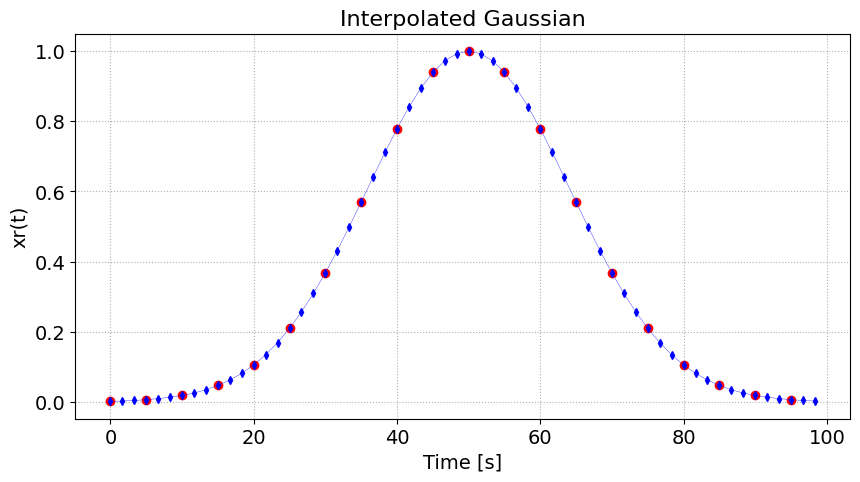

In [11]:
fig1, ax1 = SetupFigure(10, 5, "Time [s]", "xr(t)", "Interpolated Gaussian", 14)
ax1.plot(tz, xr, color='blue', ls='-', lw=0.25, marker='d', markersize=4, zorder=10)
ax1.plot(t, g, color='red', ls='', marker='o', markersize=6, zorder=5)

## Task 3: Aliasing and the sampling theorem

First, calculate values for a Gaussian with dt=0.25, period=100, tmax=50 and hwidth=1. Plot the Gaussian.

Second, in a loop, calculate sme Gaussian with dt = 0.5, 1.0, 1.5 and 2.0. Compute the fast Fourier coefficients and the frequencies associated with them. Plot the absolute value of the coefficients into one graph. Set the upper frequency axis limit to 1.0 and use different colors for the curves. Compare the spectra, what do you observe?

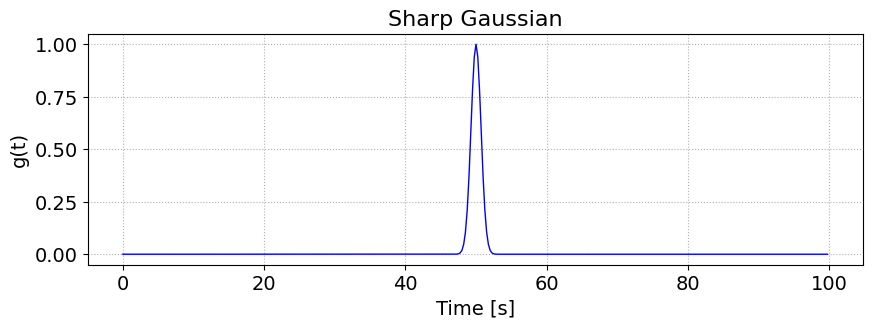

In [12]:
t, g = gaussian(0.25, 100, 50, 1)
fig3, ax3 = SetupFigure(10, 3, "Time [s]", "g(t)", "Sharp Gaussian", 14)
ax3.plot(t, g, color='blue', ls='-', lw=1.0)

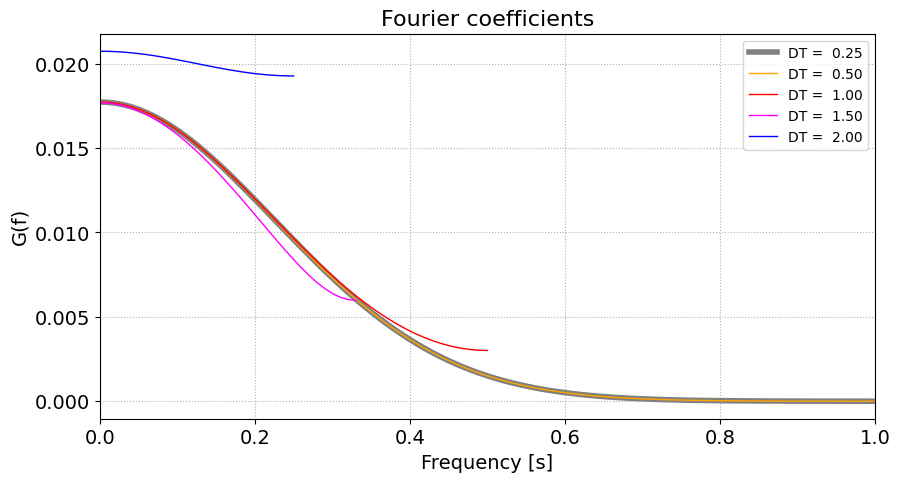

In [13]:
fig2, ax2 = SetupFigure(10, 5, "Frequency [s]", "G(f)", "Fourier coefficients", 14)
ax2.set_xlim(0, 1.0)
col = ['grey', 'orange', 'red', 'magenta', 'blue']
lw = [4, 1, 1, 1, 1]
for i, dt in enumerate([0.25, 0.5, 1.0, 1.5, 2.0]):
    t, g = gaussian(dt, 100, 50, 1)
    c = dft_fast_coeff(g)
    f = 1./period*np.arange(0, c.size)
    ax2.plot(f, np.absolute(c), color=col[i], ls='-', lw=lw[i], label="DT = {:5.2f}".format(dt))
ax2.legend()    